In [1]:
from typing import Annotated, Sequence, List, Literal 
from pydantic import BaseModel, Field 
from langchain_core.messages import HumanMessage
from langgraph.types import Command 
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import create_react_agent 

from dotenv import load_dotenv
load_dotenv()

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-5-nano")

In [17]:
class Supervisor(BaseModel):
    next: Literal["make_appointment"] = Field(
        description="Determines which specialist to activate next in the workflow sequence: "
                    "'make_appointment' : used when a user describes their symptoms, wants to book an appointment, or consult a doctor. "
    )
    reason: str = Field(
        description="Short justification for the routing decision, explaining the rationale behind selecting the particular specialist and how this advances the task toward completion."
    )

def supervisor_node(state: MessagesState) -> Command[Literal["make_appointment"]]:

    system_prompt = ('''
                 
        You are a workflow supervisor managing a team of one specialized agents: Make Appointment. 
        \n
        Your role is to orchestrate the workflow by selecting the most appropriate next agent based on the current state and needs of the task. Provide a clear, concise rationale for each decision to ensure transparency in your decision-making process.

        **Team Members**:
        1. **Make Appointment**: Always consider this agent first. They clarify of user when they share there health issue, symptoms, improve poorly defined queries, and ensure the task is well-structured before deeper processing begins.

        **Your Responsibilities**:
        1. Analyze each user request and agent response for completeness, accuracy, and relevance.
        2. Route the task to the most appropriate agent at each decision point.
        3. Maintain workflow momentum by avoiding redundant agent assignments.
        4. Return the response directly from the agents do not try to modifiy it.

        Your objective is to create an efficient workflow that leverages each agent's strengths while minimizing unnecessary steps, ultimately delivering complete and accurate solutions to user requests.
                 
    ''')
    
    messages = [
        {"role": "system", "content": system_prompt},  
    ] + state["messages"] 

    response = llm.with_structured_output(Supervisor).invoke(messages)

    goto = response.next
    reason = response.reason

    print(f"--- Workflow Transition: Supervisor → {goto.upper()} ---")
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=reason, name="supervisor")
            ]
        },
        goto=goto,  
    )

In [14]:
def make_appointment_node(state: MessagesState) -> Command[Literal["supervisor"]]:

    """
        Make Appointment agent node that check user symptoms and clarifies user queries.
        Takes the original user input and transforms it into a more precise,
        actionable request before passing it to the supervisor.
    """
   
    system_prompt = (
        "You are a Specialist with expertise in Health requests into precise instructions. Your responsibilities include:\n\n"
        "1. Analyzing the original query to identify key symptoms ('fever', 'headache', 'backpain') and requirements\n"
        "2. Resolving any ambiguities without requesting additional user input\n"
        "3. Expanding underdeveloped aspects of the query with reasonable assumptions\n"
        "4. Restructuring the query for clarity and actionability\n"
        "5. Ensuring all technical terminology is properly defined in context\n\n"
        "Important: If user not showing your symptoms, Questions back to the user."

        "If user not showing there symptoms tell him in short please give me your details or what is your health status"
    )

    messages = [
        {"role": "system", "content": system_prompt},  
    ] + state["messages"]  

    enhanced_query = llm.invoke(messages)

    print(f"--- Workflow Transition: Make Appointment → Supervisor ---")

    return Command(
        update={
            "messages": [  
                HumanMessage(
                    content=enhanced_query.content, 
                    name="make_appointment"  
                )
            ]
        },
        goto="supervisor", 
    )


In [8]:
# System prompt providing clear instructions to the validator agent
system_prompt = '''
    Your task is to ensure reasonable quality. 
    Specifically, you must:
    - Review the user's question (the first message in the workflow).
    - Review the answer (the last message in the workflow).
    - If the answer addresses the core intent of the question, even if not perfectly, signal to end the workflow with 'FINISH'.
    - Only route back to the supervisor if the answer is completely off-topic, harmful, or fundamentally misunderstands the question.
    
    - Accept answers that are "good enough" rather than perfect
    - Prioritize workflow completion over perfect responses
    - Give benefit of doubt to borderline answers
    
    Routing Guidelines:
    1. 'supervisor' Agent: ONLY for responses that are completely incorrect or off-topic.
    2. Respond with 'FINISH' in all other cases to end the workflow.
'''

class Validator(BaseModel):
    next: Literal["supervisor", "FINISH"] = Field(
        description="Specifies the next worker in the pipeline: 'supervisor' to continue or 'FINISH' to terminate."
    )
    reason: str = Field(
        description="The reason for the decision."
    )

def validator_node(state: MessagesState) -> Command[Literal["supervisor", "__end__"]]:

    user_question = state["messages"][0].content
    agent_answer = state["messages"][-1].content

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_question},
        {"role": "assistant", "content": agent_answer},
    ]

    response = llm.with_structured_output(Validator).invoke(messages)

    goto = response.next
    reason = response.reason

    if goto == "FINISH" or goto == END:
        goto = END  
        print(" --- Transitioning to END ---")  
    else:
        print(f"--- Workflow Transition: Validator → Supervisor ---")
 

    return Command(
        update={
            "messages": [
                HumanMessage(content=reason, name="validator")
            ]
        },
        goto=goto, 
    )

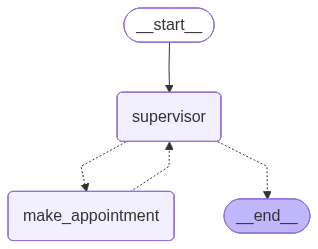

In [18]:
graph = StateGraph(MessagesState)

graph.add_node("supervisor", supervisor_node) 
graph.add_node("make_appointment", make_appointment_node)  

graph.add_edge(START, "supervisor")  
workflow = graph.compile()
workflow

In [19]:
import pprint

inputs = {
    "messages": [
        ("user", "Hello, My name is smith"),
    ]
}

for event in workflow.stream(inputs):
    for key, value in event.items():
        if value is None:
            continue
        last_message = value.get("messages", [])[-1] if "messages" in value else None
        if last_message:
            pprint.pprint(f"Output from node '{key}':")
            pprint.pprint(last_message, indent=2, width=80, depth=None)
            print()

--- Workflow Transition: Supervisor → MAKE_APPOINTMENT ---
"Output from node 'supervisor':"
HumanMessage(content='User provided only their name and no health issue or reason for contact. To proceed, Make Appointment should clarify health concerns, symptoms, or appointment purpose (checkup, specific issue, or triage) and collect necessary details to structure the task.', additional_kwargs={}, response_metadata={}, name='supervisor', id='0de375e8-95d2-45a1-a53e-e693b8a6686a')

--- Workflow Transition: Make Appointment → Supervisor ---
"Output from node 'make_appointment':"
HumanMessage(content='Hi Smith. I can help book an appointment. Since you haven’t mentioned a health concern yet, please share your current health status or the purpose of the visit. For clarity, here are quick questions to guide us:\n\n- Health status/symptoms: Are you experiencing any symptoms now? If yes, describe them (for example fever, headache, back pain), when they started, how severe (0–10), and whether they’r

KeyboardInterrupt: 